# Hindcast/Assimilation Prediction Demo

Aaron Spring and Riley Brady

---

This demo demonstrates the capabilities of the prediction module for a decadal prediction hindcast ensemble. This differs from the "perfect-model" approach of, e.g., the MPI decadal prediction system. For a perfect-model approach, see `perfect-model_predictability.ipynb`.


## Language

---

Language in the decadal prediction community is nuanced (see reference 3). It is important to distinguish the basic metrics of predictability for a hindcast/assimilation-based system. What are we comparing the actual DPLE to?

`predictability` : The DPLE ensemble mean correlated with the hindcast. The DPLE was initialized from the hindcast, but is integrated forward as a freely coupled model. This correlation coefficient (at various leads) communicates the *potential* for the climate system to be predicted. Note that one can also correlate an uninitialized ensemble (e.g., the CESM-LENS) to the hindcast to see how well an initialized ensemble does relative to an uninitialized one.

`skill` : The DPLE ensemble mean correlated to observations. How well does the initialized ensemble do at predicting the real world?

`persistence` : The hindcast lag-correlated to itself. This is a persistence prediction, i.e., predicting that next month/year will be the same as the last. This communicates whether investment into the DPLE is even worth it. For some systems/regions, persistence is plenty skillful. 

## Outline

---


## References

---

1. **Official manuscript of the CESM-DPLE release:** Yeager, S. G., et al. "Predicting near-term changes in the Earth System: A large ensemble of initialized decadal prediction simulations using the Community Earth System Model." Bulletin of the American Meteorological Society 2018 (2018). 


2. **Applied case of the DPLE on air-sea CO$_{2}$ fluxes:** Lovenduski, N. S., Yeager, S. G., Lindsay, K., and Long, M. C.: Predicting near-term changes in ocean carbon uptake, Earth Syst. Dynam. Discuss., https://doi.org/10.5194/esd-2018-73, in review, 2018. 


3. **Broad overview of decadal climate prediction and terminology:** Meehl, Gerald A., et al. "Decadal climate prediction: an update from the trenches." Bulletin of the American Meteorological Society 95.2 (2014): 243-267.

Input:
- 1-dimensional xr.Dataset timeseries output

Shows:
- Skill score (ACC, RMSE) after removing trend

---

Status:
- first small demo so far

Questions:
- Where to handle detrending? outside hindcast_compute
- How to handle detrending? So far removes linear trend. (Also depends how input data anomaly was obtained. How?)

In [82]:
from esmtools.prediction import (_pearson_r, _rmse, xr_predictability_horizon)
import esmtools.stats as st
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
#import seaborn as sb
#from esmtools.stats import xr_linregress
import matplotlib as mpl
#import proplot as plot # Nice viz package

In [ ]:
import proplot as plot

For this demo, I'm using `proplot` from https://github.com/lukelbd/proplot. If you're compiling this notebook on your own, you need to run `plot.install_fonts()` and then restart your notebook.

In [75]:
plot.nbsetup()
# Set global settings
def set_aeshetics(ax, cb=None, cb_label=None):
    """
    Cannot find any rcParam for colorbar-related
    axes. Have to go about it this way.
    """
    rc_kw = {'axes.labelsize': 14,
             'figure.titlesize': 20,
             'figure.facecolor': 'w',
             'fontname': 'Helvetica Neue',
    }
    if cb is not None:
        cb.ax.tick_params(labelsize=12)
    if cb_label is not None:
        cb.set_label(cb_label, fontsize=12)
    ax.format(rc_kw=rc_kw)

Configured ipython notebook.


# Load sample data

---

`esmtools` contains a folder with post-processed sample data for MPI and CESM ensembles. To avoid supplying massive files, these are computed as global averages.

## Hindcast

---

The CESM-DPLE (Community Earth System Model-Decadal Prediction Large Ensemble) is initialized from a forced ocean sea-ice (FOSI) hindcast. This hindcast mainly uses CORE winds (i.e., a data atmosphere), with active (or modeled) ocean and sea ice components. It has been shown to reasonably reproduce historical ocean conditions, including El Niño events.

The hindcast output is provided at monthly resolution, but for the purpose of this demo, we will just look at annual means.

In [11]:
def _load_hindcast():
    hind = xr.open_dataset('../sample_data/prediction/g.e11_LENS.GECOIAF.T62_g16.009.pop.h.SST.024901-031612.nc')
    hind = hind.drop(['z_t', 'time_bound']) # unneeded variables
    # Resample to annual means
    hind = hind.groupby('time.year').mean('time')
    # Same timeframe as dple
    hind = hind.sel(year=slice(1955,2015))
    hind = hind.rename({'year': 'ensemble'}) # corresponds to language used in package
    return hind['SST']

In [12]:
hind = _load_hindcast()

The hindcast comes out as raw output, but we want to compare it directly to the anomalies provided by the DPLE. For annual averages, we just subtract the mean of the simulation. For monthly output, we have to remove monthly climatologies.

In [13]:
hind = hind - hind.mean('ensemble')

Adjusting gridspec.
Resetting rcparams.


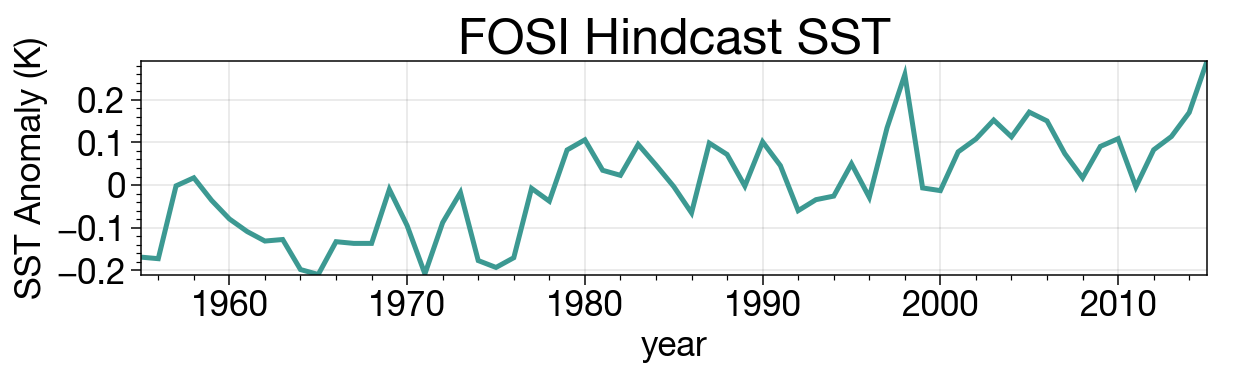

In [14]:
f, ax = plot.subplots(axwidth=6, aspect=5)
ax.plot(hind.ensemble, hind, linewidth=2, color='sea')
set_aeshetics(ax)
ax.format(xlabel='year', ylabel='SST Anomaly (K)', title='FOSI Hindcast SST')

## CESM Decadal Prediction Large Ensemble

---

Here, we load in the actual initialized CESM-DPLE to compute prediction metrics with (see intro to notebook).

In [15]:
def _load_dple():
    dple = xr.open_dataset('../sample_data/prediction/CESM-DP-LE.SST.annmean.anom.nc') \
             .rename({'anom': 'SST'})
    # Renames to standards expected in this package. This might be incorporated as
    # a function, although it's such minimal processing that it should be up to the
    # user.
    dple = dple.rename({'S':'ensemble','M':'member','L':'time'})
    dple = dple.sel(ensemble=slice(1955, 2015))
    return dple

In [16]:
dple = _load_dple()
dple_mean = dple.mean('member')['SST']

In [17]:
dple.info()
dple = dple['SST'] # easier to work with DataArray since we don't have other variables

xarray.Dataset {
dimensions:
	ensemble = 61 ;
	member = 40 ;
	time = 10 ;

variables:
	float32 SST(ensemble, time, member) ;
	int32 ensemble(ensemble) ;
		ensemble:long_name = ensemble ;
		ensemble:description = historical year corresponding to forecast year 1 ;
		ensemble:example = S=1955 for forecasts initialized on November 1 1954 ;
	int32 member(member) ;
		member:long_name = ensemble member ;
	int32 time(time) ;
		time:long_name = forecast year ;

// global attributes:
}

### Ensemble Mean Perspective

---

Here, we are just looking at the structure of the ensemble. We take the ensemble mean (of all 40 members) and plot the prediction lead year vs. the initialization year of the ensemble.

Adjusting gridspec.
Resetting rcparams.


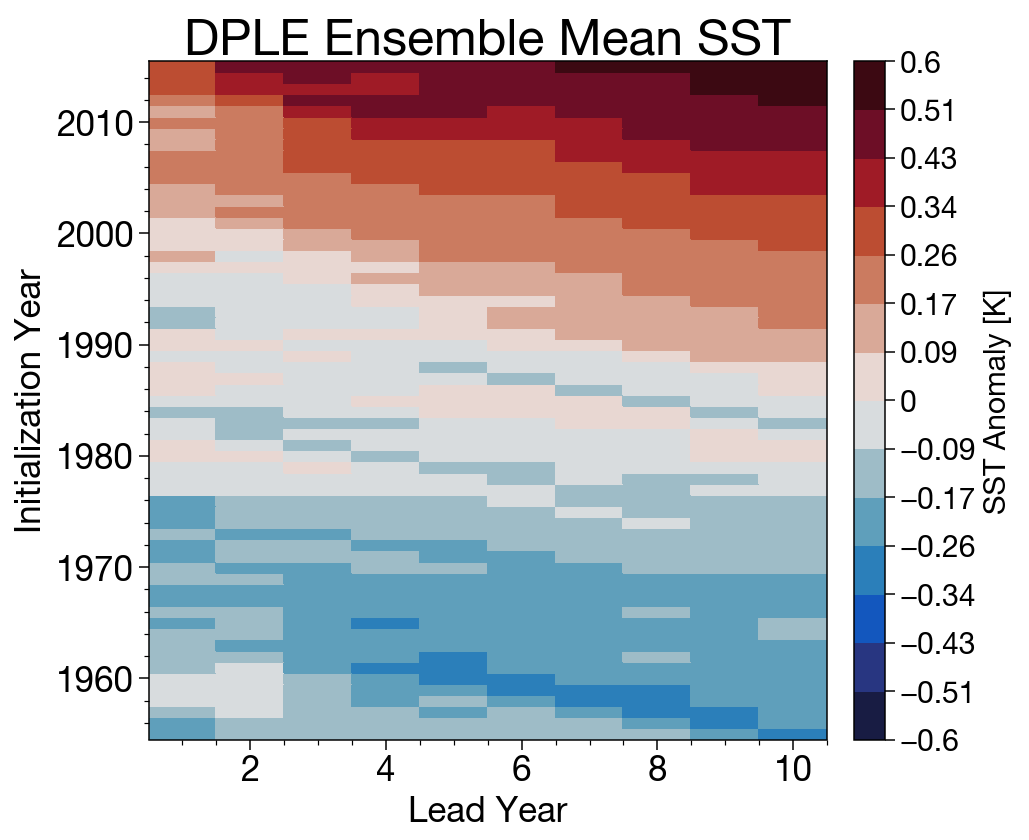

In [41]:
# NOTE: CHANGE TO PCOLORMESH. PYTHON3.7 ERRORS CURRENTLY WHEN MAKING
# A COLORBAR WITH ANYTHING BUT CONTOURS
f, ax = plot.subplots(axwidth=4, aspect=1, rightpanel=True)
m = ax.pcolormesh(dple_mean.time, dple_mean.ensemble, dple_mean,
                  vmin=-0.6, vmax=0.6, cmap="Balance", rowmajor=True, levels=15)
cb = f.rightpanel.colorbar(m)
set_aeshetics(ax, cb=cb, cb_label='SST Anomaly [K]')
ax.format(xlabel='Lead Year', ylabel='Initialization Year', title='DPLE Ensemble Mean SST')
cb.ax.tick_params(labelsize=12)

### Lead Year 1 timeseries for all members

---

Another view of the ensemble. Here, we are only looking at the prediction for one year out, i.e., after the November 1st initialization, what does the annual mean forecast look like for the following year?

Adjusting gridspec.
Resetting rcparams.


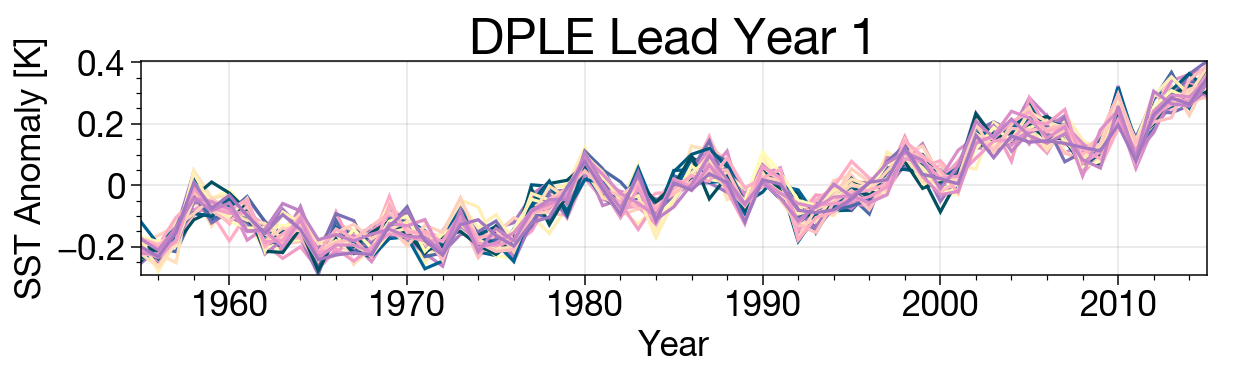

In [42]:
f, ax = plot.subplots(axwidth=6, aspect=5)
ax.plot(dple.ensemble, dple.isel(time=0), cycle=('Sunrise', 15))
set_aeshetics(ax)
ax.format(xlabel='Year', ylabel='SST Anomaly [K]', title='DPLE Lead Year 1')

### Ensemble Mean Lead Year Predictions

---

Here, we take the ensemble mean again, but look at predictions for various lead years from 1 (blue/purple) to 10 (yellow) and compare it to our reference hindcast (thick black line).

Adjusting gridspec.
Resetting rcparams.


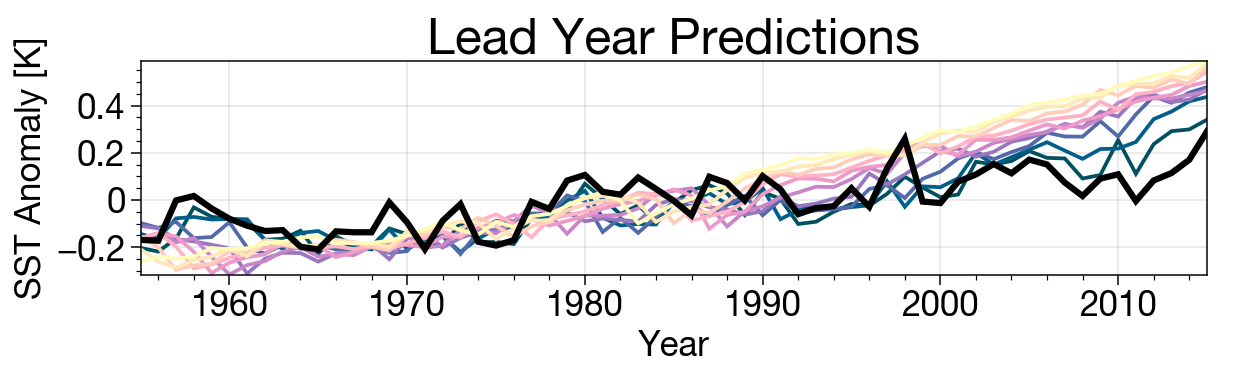

In [43]:
f, ax = plot.subplots(axwidth=6, aspect=5)
ax.plot(dple.ensemble, dple.mean('member'), linewidth=1.5, cycle=('Sunrise_r', 10))
ax.plot(hind.ensemble, hind, color='k', linewidth=2.5, label='FOSI Hindcast Mean')
set_aeshetics(ax)
ax.format(xlabel='Year', ylabel='SST Anomaly [K]', title='Lead Year Predictions')

## Basic Prediction Metrics

---

Looking at predictability vs. persistence, etc.

### Load Uninitialized Ensemble

---

A unique feature of the CESM-DPLE is that there is a complementary uninitialized "Large Ensemble." 

In [55]:
cesmLE = xr.open_dataarray('../sample_data/prediction/' +
                           'CESM-LE.global_mean.SST.1955-2015.nc') \
           .rename({'time': 'ensemble'})
# remove mean to generate anomaly like other
cesmLE = cesmLE - cesmLE.mean('ensemble')

### Ensemble Mean Plots

Adjusting gridspec.
Resetting rcparams.


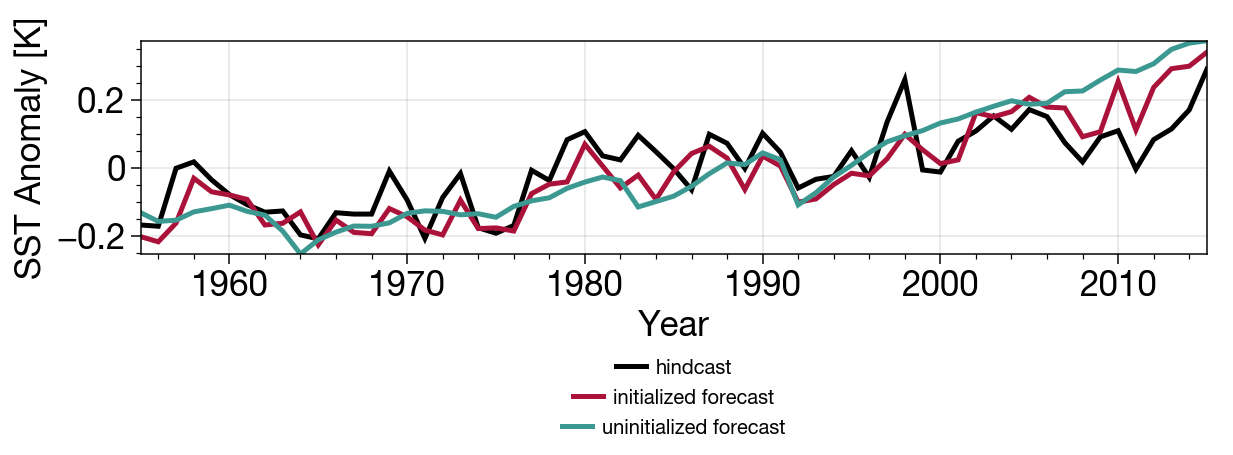

In [80]:
f, ax = plot.subplots(axwidth=6, aspect=5, bottomlegend=True)

# Hindcast mean
p1 = ax.plot(hind.ensemble, hind, color='k', linewidth=2,
             label='hindcast')
# DPLE mean
p2 = ax.plot(dple.ensemble, dple_mean.isel(time=0), color='rouge', 
             linewidth=2, label='initialized forecast')
# CESM-LENS mean
p3 = ax.plot(cesmLE.ensemble, cesmLE, color ='sea', linewidth=2,
             label='uninitialized forecast')

f.bottompanel.legend([p1, p2, p3])
set_aeshetics(ax)
ax.format(xlabel='Year', ylabel='SST Anomaly [K]')

### Predictability/Skill

---

**NEED TO EITHER WORK OUT THEORY OR FUNCTIONS HERE -- SOMETHING IS WRONG**

In [122]:
def _ACF(da, N):
    """
    Should become a functions in esmtools. Computes autocorrelation for
    a time series out to some N.
    """
    r = xr.DataArray([], dims=['lag'])
    for i in np.arange(1, N+1):
        temp_r, temp_p = st.xr_autocorr(da, lag=i, dim='ensemble')
        r = xr.concat([temp_r, r], dim='lag')
    return r

In [132]:
from statsmodels.tsa.stattools import acf as acf
# Persistence: Autocorrelation of hindcast
r = _ACF(hind, 10)

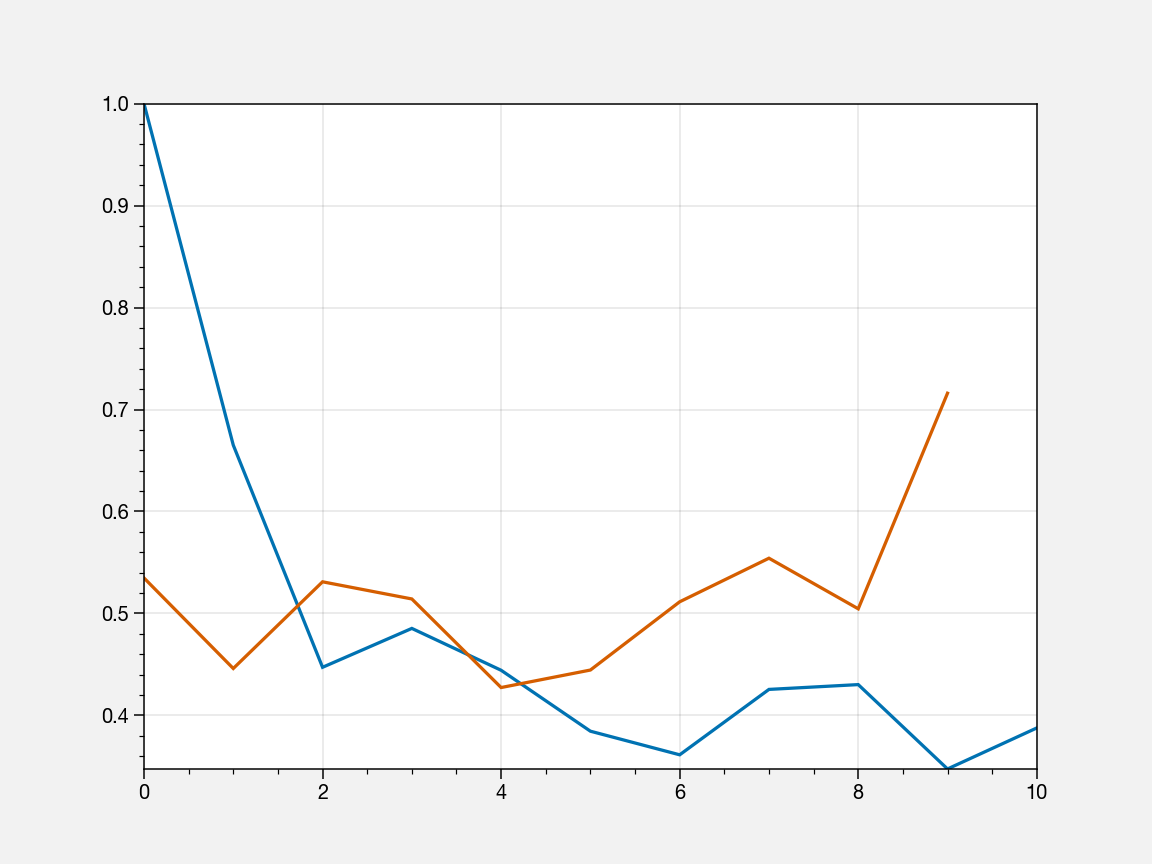

In [138]:
plt.plot(acf(hind, nlags=10))
plt.plot(r)

# Prediction module for hindcasts

In [ ]:
# the comparison functions are basically the same as xr.broadcast (I want 
# to have forecast and truth in the same dimensions), but it this
# implementation here runs at double speed compared to xr.broadcast

def _e2a(DPE, assim):
    """Compare ensemble member mean forecast with assimilation."""
    fct = DPE.mean('member')
    truth = assim.expand_dims('time')
    ntime = DPE.time.size
    truth = truth.isel(time=[0]*ntime)
    truth['time'] = np.arange(1,1+ntime)
    return fct, truth

def _m2a(DPE, assim):
    """Compare every ensemble member forecast with assimilation."""
    fct = DPE
    truth = assim.expand_dims('time').expand_dims('member')
    ntime = DPE.time.size
    nmember = DPE.member.size
    truth = truth.isel(member=[0]*nmember,time=[0]*ntime)
    truth['time'] = np.arange(1,1+ntime)
    truth['member'] = np.arange(1,1+nmember)
    return fct, truth

def hindcast_compute(DPE, assim, metric=_pearson_r, comparison=_e2a, time_dim='ensemble'):
    """
    Compute a predictability skill score for a perfect-model framework simulation dataset.

    Relies on two concepts yielding equal results (see comparisons):
    - np vectorized from xskillscore (_rmse, _pearson_r) but manually 'stacked' (_m2m, m2e, ...)
    - xarray vectorized (_mse, _rmse_v, ...) from ensemble variance (_ens_var_against_mean, _..control)

    Parameters
    ----------
    DPE, assim : Decadal Prediction Ensemble and Assimilation xr.Dataset with
                 time_dim dimension (optional spatial coordinates)
        input data
    metric : function
        metric from [_rmse, _pearson_r]
    comparison : function
        comparison from [_m2a, _e2a]
    time_dim : str
        Name of the time dimension (likely 'year' or 'time')

    Returns
    -------
    res : xr.DataArray or xr.Dataset
        skill score
    """
    if comparison.__name__ not in ['_e2a', '_m2a']:
        raise ValueError('specify comparison argument')

    if metric.__name__ in ['_pearson_r', '_rmse']:
        fct, truth = comparison(DPE,assim)
        res = metric(fct, truth,'ensemble')
        if comparison.__name__ is '_m2a':
            res = res.mean('member')
        return res
    else:
        raise ValueError('specify metric argument')

Approach for bootstrapping: Shuffle ensemble dimension

In [ ]:
def _shuffle_ensembles(DPE):
    """Shuffle ensemble dimension for bootstrapping."""
    enslist = DPE.ensemble.values
    ens = enslist.copy()
    np.random.sample(enslist)
    DPE_shuffled = DPE.sel(ensemble=enslist)
    DPE_shuffled['ensemble'] = ens
    return DPE_shuffled

import random
def _shuffle(ds,dim='ensemble'):
    dimval = ds[dim].values
    dimval_new = np.random.permutation(dimval)
    ds_shuffled = ds.sel({dim:dimval_new})
    if isinstance(ds_shuffled,xr.Dataset):
        ds_shuffled = ds_shuffled.assign({dim:dimval})
    elif isinstance(ds_shuffled,xr.DataArray):
        ds_shuffled[dim] = dimval
    return ds_shuffled

def hindcast_sig(DPE, assim, metric=_pearson_r, comparison=_e2a, sig=99, bootstrap=300):
    """
    Return sig-th percentile of function to be choosen from shuffled DPE.

    Parameters
    ----------
    DPE, assim : xr.DataArray/Dataset with time_dim dimension
        input data
    sig: int or list
        Significance level for bootstrapping from pseudo ensemble
    bootstrap: int
        number of iterations

    Returns
    -------
    sig_level : xr.DataArray/Dataset as inputs
        significance level without time_dim, ensemble and member dimensions
        as many sig_level as listitems in sig

    """
    x = []
    for _ in range(1 + int(bootstrap / DPE['time'].size)):
        ds_pseudo = _shuffle(DPE)
        ds_pseudo_metric = hindcast_compute(
            ds_pseudo, assim, metric=metric, comparison=comparison)
        x.append(ds_pseudo_metric)
    ds_pseudo_metric = xr.concat(x, dim='it')
    if isinstance(sig, list):
        qsig = [x / 100 for x in sig]
    else:
        qsig = sig / 100
    sig_level = ds_pseudo_metric.quantile(q=qsig, dim=['time', 'it'])
    return sig_level

In [ ]:
def get_limit_sig(metric=_pearson_r,sig=99):
    if metric.__name__ in ['_pearson_r', '_PPP', '_PM_MSSS']:
        limit = 'upper'
        sigl = sig
    else:
        limit = 'lower'
        sigl = 100 - sig
    return limit, sigl

Notes
---
- I think we are making our coding very difficult with the time_dim argument. Isnt it much easier if we just agree whether to use time or year? Independent of the choice we make, do we need to have this flexible? To me it seems much easier to rename dimensions in the beginning and then just run the code.
- Now this code can only compute the metrics ACC and RMSE because those are implemented based on numpy in xskillscore https://github.com/raybellwaves/xskillscore. 
    - What do you think about adding the few needed metrics by ourselves? MSE, MAE can be probably easily adapted from this.
- So far the rest of the prediction module works always on xr.Datasets (and mostly also for xr.DataArrays). 

# Prediction skill

In [ ]:
bootstrap=1000
sig=99
metric=_pearson_r
comparison=_e2a

## raw anomaly data

In [ ]:
DPE.mean('member').to_dataframe()[varname].unstack().plot()
assim[varname].plot(lw=3,color='k',label='Assimilation')
plt.title('Lead year timeseries and assimilation without removing trend')
plt.legend()

In [ ]:
skill = hindcast_compute(DPE, assim, metric=metric,comparison=comparison)

In [ ]:
for metric in [_pearson_r,_rmse]:
    limit, sigl = get_limit_sig(metric=metric, sig=sig)
    for comparison in [_e2a,_m2a]:
        # compute hindcast skill
        skill = hindcast_compute(DPE, assim,metric=metric,comparison=comparison)
        skill[varname].plot(label=' '+metric.__name__+' '+comparison.__name__)
        # bootstrap threshold
        threshold = hindcast_sig(DPE,assim, metric=metric,comparison=comparison, bootstrap=bootstrap, sig=sigl)[varname].values
        plt.axhline(y=threshold, ls=':',c='gray',label='bootstrap n='+str(bootstrap)+' threshold '+str(sig)+'% significance')
        ph = xr_predictability_horizon(skill, threshold, limit=limit)[varname].values
        plt.axvline(x=ph,ls='-.',c='gray',label='Predictability Horizon')
    plt.legend()
    plt.title(metric.__name__+' Skill Score without removing trend')
    plt.show()

quite high (artificial) ACC prediction skill due to climate change forcing

## detrend by linear fit

In [ ]:
n=1
detrended_DPE = esmtools.stats.xr_rm_poly(DPE[varname],n, dim='ensemble').to_dataset(varname)
detrended_assim = esmtools.stats.xr_rm_poly(assim[varname],n, dim='ensemble').to_dataset(varname)

In [ ]:
detrended_DPE.mean('member').to_dataframe()[varname].unstack().plot()
detrended_assim.to_dataframe()[varname].plot(lw=3,color='k',label='Assimilation')
plt.legend()
plt.title('Lead year timeseries and assimilation after removing linear trend')

probably a 2nd order polynomial does better

In [ ]:
for metric in [_pearson_r,_rmse]:
    limit, sigl = get_limit_sig(metric=metric, sig=sig)
    for comparison in [_e2a,_m2a]:
        # compute hindcast skill
        skill = hindcast_compute(detrended_DPE, detrended_assim,metric=metric,comparison=comparison)
        skill[varname].plot(label=' '+metric.__name__+' '+comparison.__name__)
        # bootstrap threshold
        threshold = hindcast_sig(detrended_DPE,detrended_assim, metric=metric, comparison=comparison, bootstrap=bootstrap, sig=sigl)[varname].values
        plt.axhline(y=threshold, ls=':',c='gray',label='bootstrap n='+str(bootstrap)+' threshold '+str(sig)+'% significance')
        ph = xr_predictability_horizon(skill, threshold, limit=limit)[varname].values
        plt.axvline(x=ph,ls='-.',c='gray',label='Predictability Horizon')
    plt.legend()
    plt.title(metric.__name__+' Skill Score after removing linear trend')
    plt.show()

## detrend via n-th order polynomial

In [ ]:
n=2
polyndetrended_DPE = esmtools.stats.xr_rm_poly(DPE[varname],n, dim='ensemble').to_dataset(varname)
polyndetrended_assim = esmtools.stats.xr_rm_poly(assim[varname],n, dim='ensemble').to_dataset(varname)

In [ ]:
polyndetrended_DPE.mean('member').to_dataframe()[varname].unstack().plot()
detrended_assim.to_dataframe()[varname].plot(lw=3,color='k',label='Assimilation')
plt.legend()
plt.title('Lead year timeseries and assimilation after removing n-th order polynomial trend')

In [ ]:
for metric in [_pearson_r,_rmse]:
    limit, sigl = get_limit_sig(metric=metric, sig=sig)
    for comparison in [_e2a,_m2a]:
        # compute hindcast skill
        skill = hindcast_compute(polyndetrended_DPE, polyndetrended_assim,metric=metric,comparison=comparison)
        skill[varname].plot(label=' '+metric.__name__+' '+comparison.__name__)
        # bootstrap threshold
        threshold = hindcast_sig(polyndetrended_DPE, polyndetrended_assim, metric=metric, comparison=comparison, bootstrap=bootstrap, sig=sigl)[varname].values
        plt.axhline(y=threshold, ls=':',c='gray',label='bootstrap n='+str(bootstrap)+' threshold '+str(sig)+'% significance')
        ph = xr_predictability_horizon(skill, threshold, limit=limit)[varname].values
        plt.axvline(x=ph,ls='-.',c='gray',label='Predictability Horizon')
    plt.legend()
    plt.title(metric.__name__+' Skill Score after removing linear trend')
    plt.show()

##  detrend via unitialised ensemble mean from CESM LE 
that should be nice